In [1]:
import os
import gc
import cv2
import numpy as np
import json

from tensorflow.keras.preprocessing.image import load_img
import segmentation_models as sm
from segmentation_models import Unet, FPN, Linknet
from segmentation_models.losses import bce_jaccard_loss
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageOps

Segmentation Models: using `keras` framework.


In [2]:
models = './results/models_v02/'
originals = './originals/'
masks = './masks/'
test_image = 'abdomen_0001.jpg'
test_mask = 'abdomen_0001.png'

In [3]:
param_file_name = 'params.json'
with open(f'{models}/{param_file_name}', 'rb') as f: 
    mparams = json.load(f)      
mparams

{'version': 'v02',
 'folds': 5,
 'img_size': 256,
 'batch_size': 20,
 'epochs': 1000,
 'patience': 20,
 'decay': False,
 'backbone': 'efficientnetb3',
 'bce_weight': 1,
 'loss': 'bce_dice',
 'seed': 1970,
 'split': 'kfold',
 'mirror': False,
 'aughard': False,
 'umodel': 'unet',
 'lr': 0.0005,
 'shift': False,
 'comments': 'first try',
 'best_avg_epoch': 68.8,
 'best_avg_loss': 0.10230410248041152,
 'best_avg_dice_coef': 0.9398624777793885,
 'dice_by_folds': '0.9435 0.9396 0.9403 0.9329 0.9429'}

In [4]:
saved_models = os.listdir(models)
saved_models = [x for x in saved_models if '.hdf5' in x]

In [5]:
# metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return cur_params['bce_weight'] * binary_crossentropy(y_true, y_pred) + \
        (1 - cur_params['bce_weight']) * dice_loss(y_true, y_pred)


def get_model(backbone, input_shape, loss_type='bce_dice', 
              umodel='unet', classes=1, lr=.001):
    with strategy.scope():
        if loss_type == 'bce_dice': 
            loss = bce_dice_loss
        elif loss_type == 'bce_jaccard_loss':
            loss = bce_jaccard_loss
        else:
            raise AttributeError('loss mode parameter error')
            
        preprocess_input = sm.get_preprocessing(backbone)
        if umodel == 'unet':
            # model = Unet(backbone_name=backbone, encoder_weights='imagenet',
            #              classes=classes, activation='sigmoid')
            model = Unet(backbone_name=backbone, encoder_weights='imagenet',
                          input_shape=input_shape,
                          classes=classes, activation='sigmoid')
        elif umodel == 'fpn':
            model = FPN(backbone_name=backbone, encoder_weights='imagenet',
                        input_shape=input_shape,
                        classes=classes, activation='sigmoid')
        elif umodel == 'link':
            model = Linknet(backbone_name=backbone, encoder_weights='imagenet',
                            input_shape=input_shape,
                            classes=classes, activation='sigmoid')
        else:
            raise AttributeError('umodel mode parameter error')
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
            loss = loss, 
            metrics = [dice_coef]
        )
    return model

In [6]:
strategy = tf.distribute.get_strategy()
with tf.device('/GPU:1'):
   
    test_models = []
    for n_fold in list(range(mparams['folds'])):
        checkpoint_path = f'{models}/model_{n_fold}.hdf5'
#         print(checkpoint_path)
        model_lrg = get_model(
                    mparams['backbone'], 
                    input_shape = (mparams['img_size'], mparams['img_size'], 3),
                    loss_type = mparams['loss'],
                    umodel = mparams['umodel']
                )
        model_lrg.load_weights(checkpoint_path) 
        test_models.append(model_lrg)        

In [7]:
def predict(test_image):
    # loading the test image
    img = load_img(originals + test_image, target_size = (mparams['img_size'], mparams['img_size']))

    prediction = []
    with tf.device('/GPU:1'):
        for j in range(len(test_models)):
            mask_lrg = test_models[j].predict(np.expand_dims(np.asarray(img, dtype='float32')  , 0))
    #         print(f'img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}')
            pred_mask = Image.fromarray(np.squeeze((mask_lrg >= 0.5) * 255).astype('uint8'), 'L')
            prediction.append(np.squeeze(np.array(mask_lrg)))
    #         prediction.append(np.array(pred_mask))
    #         display(pred_mask)
    mean_pred = np.array(prediction).mean(axis=0)
    return mean_pred

In [20]:
def show_test_image(originals, test_image, masks, test_mask, pred_mask):
# def show_test_image(test_image, test_mask, pred_mask):
    N_rows = 1
    N_cols = 3
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(10)

    ax = fig.add_subplot(N_rows, N_cols, 1)
    img = load_img(originals + test_image, target_size = (mparams['img_size'], mparams['img_size']))
    imgplot = plt.imshow(img)
    ax.set_title('Original image')
    plt.axis('off')

    ax = fig.add_subplot(N_rows, N_cols, 2)
    msk = load_img(masks + test_mask, target_size = (mparams['img_size'], mparams['img_size']), color_mode="grayscale")
    imgplot = plt.imshow(msk, cmap='gray')
    ax.set_title('Original mask')
    plt.axis('off')

    ax = fig.add_subplot(N_rows, N_cols, 3)
    pred_mask_bin = (pred_mask >= 0.5).astype('uint8')
    predicted_msk = Image.fromarray(pred_mask_bin * 255, 'L')
    imgplot = plt.imshow(predicted_msk, cmap='gray')
    ax.set_title('Predicted mask')
    plt.axis('off')

    print(type(pred_mask_bin))
    print(pred_mask_bin.sum())
    print(type(msk))
    print((np.asarray(msk)/255).astype('uint8').sum())
    dc = dice_coef((np.asarray(msk)/255).astype('uint8'), np.asarray(pred_mask_bin))
    plt.title(f'Dice coefficient = {dc:.2f}')
    plt.plot()

    msk_size = np.asarray(predicted_msk).shape[0] * np.asarray(predicted_msk).shape[1]
    skin = np.asarray(pred_mask_bin).sum()
    skin_ratio = skin / msk_size
    print(f'Estimated {skin_ratio * 100:.1f}% of the image contains skin')

In [9]:
mean_pred = predict(test_image)

1/1 [==============================] - 2s 2s/step


<class 'numpy.ndarray'>
38419
<class 'PIL.Image.Image'>
44187
Estimated 58.6% of the image contains skin


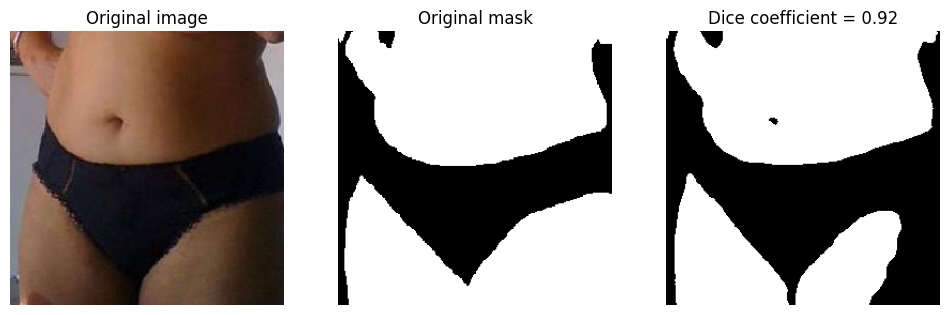

In [10]:
show_test_image(test_image, test_mask, mean_pred)

In [11]:
mean_pred = predict('skin_image_0905.jpg')

1/1 [==============================] - 0s 41ms/step


<class 'numpy.ndarray'>
20023
<class 'PIL.Image.Image'>
19148
Estimated 30.6% of the image contains skin


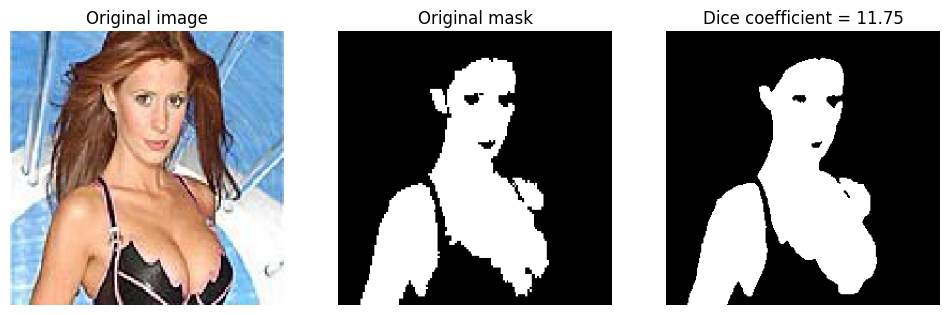

In [12]:
show_test_image('skin_image_0905.jpg', 'skin_image_0905.bmp', mean_pred)

In [13]:
type(mean_pred[0,0])


numpy.float32

In [14]:
msk = load_img(masks + 'skin_image_0905.bmp', target_size = (mparams['img_size'], mparams['img_size']), color_mode="grayscale")

In [15]:
type(msk)

PIL.Image.Image

In [17]:
img = load_img('Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\originals\!AK_skin_image_0034.jpg', target_size = (mparams['img_size'], mparams['img_size']))

prediction = []
with tf.device('/GPU:0'):
    for j in range(len(test_models)):
        mask_lrg = test_models[j].predict(np.expand_dims(np.asarray(img, dtype='float32')  , 0))
#         print(f'img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}')
        pred_mask = Image.fromarray(np.squeeze((mask_lrg >= 0.5) * 255).astype('uint8'), 'L')
        prediction.append(np.squeeze(np.array(mask_lrg)))
#         prediction.append(np.array(pred_mask))
#         display(pred_mask)
mean_pred = np.array(prediction).mean(axis=0)

1/1 [==============================] - 1s 910ms/step


<class 'numpy.ndarray'>
58316
<class 'PIL.Image.Image'>
53276
Estimated 89.0% of the image contains skin


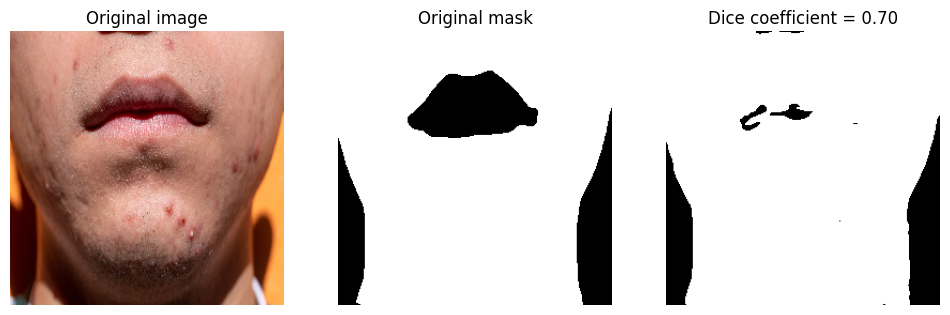

In [26]:
show_test_image("Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\originals/", '!AK_skin_image_0034.jpg', "Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\masks/", '!AK_skin_image_0034.png', mean_pred)

In [ ]:
img = load_img('Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\originals\!AK_skin_image_0034.jpg', target_size = (mparams['img_size'], mparams['img_size']))

prediction = []
with tf.device('/GPU:0'):
    for j in range(len(test_models)):
        mask_lrg = test_models[j].predict(np.expand_dims(np.asarray(img, dtype='float32')  , 0))
#         print(f'img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}')
        pred_mask = Image.fromarray(np.squeeze((mask_lrg >= 0.5) * 255).astype('uint8'), 'L')
        prediction.append(np.squeeze(np.array(mask_lrg)))
#         prediction.append(np.array(pred_mask))
#         display(pred_mask)
mean_pred = np.array(prediction).mean(axis=0)

In [ ]:
show_test_image("Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\originals/", '!AK_skin_image_0034.jpg', "Y:\Projects\VA_Melanoma\Skin_Segmentation\mine\masks/", '!AK_skin_image_0034.png', mean_pred)